In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pylab as pl

# For brevity, limit the number of rows displayed in the default output
pd.options.display.max_rows = 10

In [3]:
# Resampling period (in msec)
resample_period = 1

# Minimum duration of missing data for detecting a blink (in msec)
blink_duration = 50

# How many msec should we discard around the blink?
blink_padding = 100

# Duration of smoothing window (in msec)
smooth_duration = 300

# Type of window to use for smoothing
smooth_window = 'hamming'

# Minimum number of samples (in msec) required to be in smoothing window.
# If more than this number of samples are missing, don't calculate a value.
smooth_duration_min = smooth_duration/4

# Interpolation method to use
interpolation_method = 'cubic' 

smooth_samples = int(smooth_duration/resample_period)
smooth_samples_min = int(smooth_duration_min/resample_period)

In [4]:
# Read in the data file. It's tab-separated (i.e., \t) and encoded in UTF 16 format.
data_2dB = pd.read_csv('pilot_high_res.tsv', encoding='utf-16', sep='\t')

There are extra rows in the dataframe that are not associated with the stimulus. These rows contain information about when the video started and ended as well as when the eye tracker calibration was complete. The rows containing information about when the video started are not associated with the stimulus name. However, the row immediately following always contains the stimulus name. Backfill by one to ensure that the timestamp for when the video started is properly associated with the stimulus.

While we're at it, discard the extra rows (pertaining to video end as well as eye tracker end) as we do not need this information.

In [5]:
# Backfill stimulus name by one row. Modify the column in place (i.e., don't return a copy)
data_2dB['Presented Stimulus name'].fillna(method='bfill', limit=1, inplace=True)

print('Rows before dropping: {}'.format(len(data_2dB)))

# Drop the extra rows. Modify the dataframe in place (i.e., don't return a copy)
data_2dB.dropna(subset=['Presented Stimulus name'], inplace=True)

print('Rows after dropping: {}'.format(len(data_2dB)))

Rows before dropping: 49956
Rows after dropping: 49904


For simplicity in coding, rename some of the columns. We will only keep these columns as well so that the extra columns are not shown in the printing of the output.

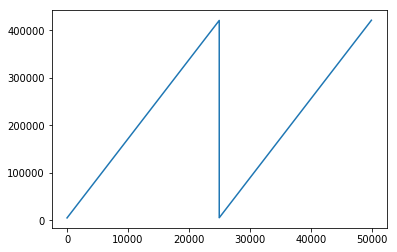

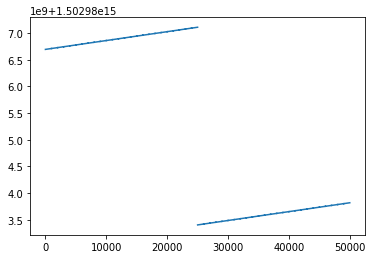

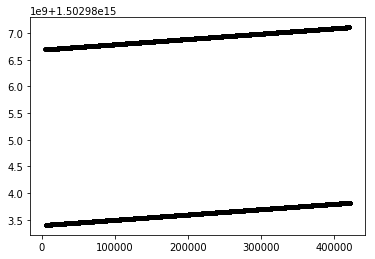

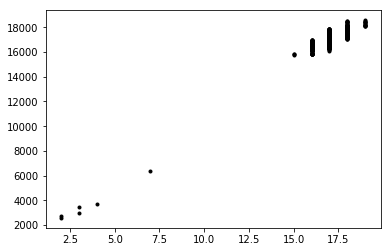

In [6]:
pl.figure()
pl.plot(data_2dB['Recording timestamp'])
pl.figure()
pl.plot(data_2dB['Eyetracker timestamp'])
pl.figure()
pl.plot(data_2dB['Recording timestamp'], data_2dB['Eyetracker timestamp'], 'k.')
pl.figure()
pl.plot(data_2dB['Recording timestamp'].diff(), data_2dB['Eyetracker timestamp'].diff(), 'k.')


In [7]:
name_map = {
    'Recording timestamp': 'timestamp',
    'Eyetracker timestamp': 'timestamp_us',
    'Pupil diameter left': 'pd_left',
    'Pupil diameter right': 'pd_right',
    'Presented Stimulus name': 'stimulus',
    'Participant name': 'subject',
    'Recording name': 'recording',
}

# Rename columns in place
data_2dB.rename(columns=name_map, inplace=True)

# List of columns to keep.
keep = name_map.values()

# Make a copy of the dataframe with only the desired columns. Note
# that we've overwritten the variable data_2dB with the copy of the
# dataframe containing the subset of columns.
data_2dB = data_2dB.loc[:, keep]

# Wherever we just put the variable name by itself at the end of a
# notebook cell, the notebook will print out the variable.
data_2dB

,timestamp,timestamp_us,pd_left,pd_right,stimulus,subject,recording
1,4992,NaN,NaN,NaN,7x2_2dB,BM,BM2dBHP
2,5002,1.502987e+15,5.28,5.28,7x2_2dB,BM,BM2dBHP
3,5019,1.502987e+15,5.27,5.29,7x2_2dB,BM,BM2dBHP
4,5036,1.502987e+15,5.35,5.27,7x2_2dB,BM,BM2dBHP
5,5052,1.502987e+15,5.13,5.54,7x2_2dB,BM,BM2dBHP
...,...,...,...,...,...,...,...
49950,421027,1.502984e+15,4.62,4.69,7x49_2dB,BM,BM2dBLP
49951,421044,1.502984e+15,4.62,4.71,7x49_2dB,BM,BM2dBLP
49952,421060,1.502984e+15,4.63,4.67,7x49_2dB,BM,BM2dBLP
49953,421077,1.502984e+15,4.60,4.63,7x49_2dB,BM,BM2dBLP


In [8]:
x = data_2dB.groupby(['subject', 'recording', 'timestamp']).size()
x[x != 1]

subject  recording  timestamp
BM       BM2dBHP    38245        2
                    187933       2
                    287703       2
         BM2dBLP    55218        2
dtype: int64

In [9]:
m = data_2dB['timestamp'] == 55218
display(data_2dB.loc[m])
#display(data_2dB.loc[1995:2000])


,timestamp,timestamp_us,pd_left,pd_right,stimulus,subject,recording
27977,55218,NaN,NaN,NaN,7x6_2dB,BM,BM2dBLP
27978,55218,1.502983e+15,NaN,NaN,7x6_2dB,BM,BM2dBLP


Check to see whether timestamp is monotonically increasing. In the plot below, it shows that the timestamp resets halfway through. After some inspection, it appears that timestamp is *always* monotonically increasing for a recording. However, in between recordings it will reset. So, when doing our analysis we need to group by recording (and possibly subject).

Text(0,0.5,'Timestamp (msec)')

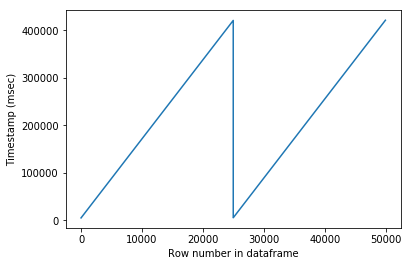

In [10]:
ax = pl.subplot(111)
ax.plot(data_2dB['timestamp'])
ax.set_xlabel('Row number in dataframe')
ax.set_ylabel('Timestamp (msec)')

Here, we are grouping the dataframe by subject and recording. For subsequent analysis, we will focus only on the subset of data from a single recording from a single participant (we'll call this subset "example"). Note that this example data is a dataframe (containing a subset of the original dataframe). 

The reason why we focus only on data from one recording from one subject is because the operations we perform in the next few steps assume that the timestamp is monotonically increasing. These operations cannot handle "resets" in the timestamp (i.e., these operations cannot simultaneously handle data from multiple recordings and/or subjects).

In [17]:
grouped = data_2dB.groupby(['subject', 'recording'])
example = grouped.get_group(('BM', 'BM2dBHP'))
example

,timestamp,timestamp_us,pd_left,pd_right,stimulus,subject,recording
1,4992,NaN,NaN,NaN,7x2_2dB,BM,BM2dBHP
2,5002,1.502987e+15,5.28,5.28,7x2_2dB,BM,BM2dBHP
3,5019,1.502987e+15,5.27,5.29,7x2_2dB,BM,BM2dBHP
4,5036,1.502987e+15,5.35,5.27,7x2_2dB,BM,BM2dBHP
5,5052,1.502987e+15,5.13,5.54,7x2_2dB,BM,BM2dBHP
...,...,...,...,...,...,...,...
24975,420627,1.502987e+15,3.99,3.89,7x50_2dB,BM,BM2dBHP
24976,420644,1.502987e+15,3.97,3.87,7x50_2dB,BM,BM2dBHP
24977,420660,1.502987e+15,4.03,3.91,7x50_2dB,BM,BM2dBHP
24978,420677,1.502987e+15,3.97,3.90,7x50_2dB,BM,BM2dBHP


Let's look at the sampling period (the spacing of consecutive timestamps). It appears that the sampling period is usually 17 msec; however, it is not uniform. This creates some difficulty with the analysis. We need to resample to a uniform timeseries. 

In [18]:
sampling_period = example.timestamp.diff()
sampling_period.describe()

count    24954.000000
mean        16.658732
std          0.639593
min          0.000000
25%         16.000000
50%         17.000000
75%         17.000000
max         19.000000
Name: timestamp, dtype: float64

First, note the minimum sampling period above is 0. That means some adjacent rows contain duplicate timestamps. Let's find where this first occurs and show the rows around it in the example dataframe.

In [20]:
# argmin returns the index where sampling_period first equals 0
i = sampling_period.idxmin()

# Show the rows around it
example.loc[i-2:i+1]

,timestamp,timestamp_us,pd_left,pd_right,stimulus,subject,recording
1998,38245,NaN,NaN,NaN,7x7_2dB,BM,BM2dBHP
1999,38245,1.502987e+15,4.90,5.17,7x7_2dB,BM,BM2dBHP
2000,38262,1.502987e+15,5.06,5.18,7x7_2dB,BM,BM2dBHP


At least in this example, the duplicated timestamp has data for pd_left in one row but not the other. We need to remove these duplicated timestamps. A simple way to do this is to group by the timestamp column and take the first not-null value for each column in the group. In the majority of cases, the group will only have one row (i.e., most of the timestamps are not duplicated). 

Where the timestamp is duplicated, the group will have two rows. In the case where the group has two rows, the first valid value in the column is returned (NaN and None values are ignored). If all values are None or NaN, then the returned value will be NaN.

After the groupby operation is performed, the dataframe (`example_clean`) will now be indexed by timestamp. The original dataframe (`example`) was indexed by row number. Since `example_clean` is indexed by timestamp, we can pull out the rows by timestamp. So, let's show the subset of `example_clean` for 20 msec before to 20 msec after the duplicated timestamp (367832). Note that the duplicated data issue has been addressed.

In [21]:
ts = 367832
example_clean = example.groupby('timestamp').first()
example_clean.loc[ts-20:ts+20]

,timestamp_us,pd_left,pd_right,stimulus,subject,recording
timestamp,,,,,,
367819,1.502987e+15,3.92,3.87,7x43_2dB,BM,BM2dBHP
367835,1.502987e+15,3.91,3.84,7x43_2dB,BM,BM2dBHP
367852,1.502987e+15,3.90,3.88,7x43_2dB,BM,BM2dBHP


Finally, we can resample the dataframe with a fixed sampling period. The best way to handle this is by upsampling to a high-resolution timeseries.  First, we need to find the start and end timestamps.

In [22]:
start = example_clean.index.min()
end = example_clean.index.max()
print('Timestamp range {} to {} msec'.format(start, end))

Timestamp range 4992 to 420694 msec


We need to round the start and end to the nearest multiple of the resample period. So, if our resampling period is 10 msec, then we would want to round 4471 to 4470 and 420392 to 430390. If our resampling period is 2 msec, then we'd round 4471 to 4470 and 420392 to 420392.

In [23]:
new_start = np.round(start/resample_period)*resample_period
new_end = np.round(end/resample_period)*resample_period
print('Resampling period is {} msec'.format(resample_period))
print('New timestamp range {:.0f} to {:.0f}'.format(new_start, new_end))

Resampling period is 1 msec
New timestamp range 4992 to 420694


Now, create a new array containing the timestamps we want in the resampled dataframe.

In [24]:
new_timestamp = np.arange(new_start, new_end, resample_period, dtype='int')
new_timestamp

array([  4992,   4993,   4994, ..., 420691, 420692, 420693])

Since `example_clean` is already indexed by timestamp, we can reindex using the new tiemstamps. Since the new timestamps are at a higher resolution, we can tell Pandas to forward fill new values with data from the last valid row in the `example_clean` dataframe. 

Compare the first three rows of `example_clean` with the first 20 rows of `example_resampled`.

In [25]:
example_clean.head(3)

,timestamp_us,pd_left,pd_right,stimulus,subject,recording
timestamp,,,,,,
4992,NaN,NaN,NaN,7x2_2dB,BM,BM2dBHP
5002,1.502987e+15,5.28,5.28,7x2_2dB,BM,BM2dBHP
5019,1.502987e+15,5.27,5.29,7x2_2dB,BM,BM2dBHP


In [26]:
# Set max number of rows to show to 20 for this particular cell
pd.options.display.max_rows = 20
example_resampled = example_clean.reindex(new_timestamp, method='ffill')
example_resampled.head(20)

,timestamp_us,pd_left,pd_right,stimulus,subject,recording
timestamp,,,,,,
4992,NaN,NaN,NaN,7x2_2dB,BM,BM2dBHP
4993,NaN,NaN,NaN,7x2_2dB,BM,BM2dBHP
4994,NaN,NaN,NaN,7x2_2dB,BM,BM2dBHP
4995,NaN,NaN,NaN,7x2_2dB,BM,BM2dBHP
4996,NaN,NaN,NaN,7x2_2dB,BM,BM2dBHP
4997,NaN,NaN,NaN,7x2_2dB,BM,BM2dBHP
4998,NaN,NaN,NaN,7x2_2dB,BM,BM2dBHP
4999,NaN,NaN,NaN,7x2_2dB,BM,BM2dBHP
5000,NaN,NaN,NaN,7x2_2dB,BM,BM2dBHP


Now, we need to find the missing data. Let's use the left eye as an example. We'll pull out the column containing the pupil dilation for the left eye. Note that it still is indexed by timestamp. When you pull a single column out of a dataframe, it retains the original dataframe index.

In [27]:
# Pull out the column containing the data we want to clean up
pd.options.display.max_rows = 10
pupil_dilation = example_resampled['pd_left']

Where are the values missing?

In [28]:
missing = pupil_dilation.isnull()
missing

timestamp
4992       True
4993       True
4994       True
4995       True
4996       True
          ...  
420689    False
420690    False
420691    False
420692    False
420693    False
Name: pd_left, Length: 415702, dtype: bool

We want to find the starts and ends of the missing data. The start of a run of missing data occurs when the value changes from False to True. The end of a run of missing data occurs when the value changes from True to False.  We can do this by computing the difference using the `diff` method. It returns a new Series indicating the difference between the value and the previous value. Note the following:

* The first value is NaN. That's because there's no previous value to compare with, so the result is undefined.

* Where the value in `missing` changes from missing (i.e., True, see timestamp 4472 above) to not missing (i.e., False, see timestamp 4773 above), the result is True (see value for timestamp 4773 below). However, the result will also be True if the value changse from not missing to missing. That's because a boolean datatype only has two values, True and False. So, False means no change between consecutive values. True means a change between consecutive values. 


We want to be able to differentiate between a True to False change and a False to True change. To do this, we need to convert the `missing` array to an integer datatype. When we do this, True (i.e., missing) is converted to 1. False (i.e., not missing) is converted to 0.

Once we've converted to an integer datatype, the result of `diff` gives us -1 (indicating the end of a missing block where the value changes from 1 to 0) and 1 (indicating the start of a missing block where the value changes from 0 to 1).

In [32]:
missing_int = missing.astype('int')
missing_diff = missing_int.diff()
missing_diff

timestamp
4992      NaN
4993      0.0
4994      0.0
4995      0.0
4996      0.0
         ... 
420689    0.0
420690    0.0
420691    0.0
420692    0.0
420693    0.0
Name: pd_left, Length: 415702, dtype: float64

To help illustrate the conversion from `missing` to `missing_int` to `missing_diff`, let's plot the columns side-by-side. The code below is just temporary code (for displaying the output) that assembles the three columns into a single dataframe and plots the columns in the desired order. We won't be using the result of this code.

In [33]:
df_data = {
    'missing': missing,
    'missing_int': missing_int,
    'missing_diff': missing_diff,
}
df = pd.DataFrame(df_data)
df[['missing', 'missing_int', 'missing_diff']]

,missing,missing_int,missing_diff
timestamp,,,
4992,True,1,NaN
4993,True,1,0.0
4994,True,1,0.0
4995,True,1,0.0
4996,True,1,0.0
...,...,...,...
420689,False,0,0.0
420690,False,0,0.0
420691,False,0,0.0


Find the rows in `missing_diff` that represent the starts and ends of the blocks of missing data.

In [34]:
starts = missing_diff[missing_diff == 1]
ends = missing_diff[missing_diff == -1]
starts

timestamp
12585     1.0
12820     1.0
12855     1.0
16723     1.0
16995     1.0
         ... 
409723    1.0
411657    1.0
411942    1.0
411976    1.0
413027    1.0
Name: pd_left, Length: 187, dtype: float64

Note that `starts` is a pandas Series where the values are all 1 (because we only selected the subset of the `missing_diff` Series was 1). We are interested in the values of the index for the series, which are the timestamps where the missing data blocks begin. 

Let's pull out the timestamps and print out the first and last four values from each.

In [36]:
start_times = starts.index.values
end_times = ends.index.values
print('Start', start_times[:4], start_times[-4:])
print('End  ', end_times[:4], end_times[-4:])

Start [12585 12820 12855 16723] [411657 411942 411976 413027]
End   [ 5002 12803 12838 12872] [411926 411960 411994 413044]


Note that the first end timestamp occurs *before* the first start timestamp. That's because in this particular dataset we started off with missing data right away. Let's fix that by adding a new start timestamp to the beginning of the start_times array.  We pick a value for the start timestamp that is `blink_duration` away from the end timestamp (ensuring that we also eliminate `blink_padding` for this segment).

Likewise, the last start timestamp occurs *after* the last end timestamp. That's because we have a run of missing data at the very end of the recording. Let's fix that as well.

Looking at the first and last four values, we see that we now have lined up the starts and ends properly.

In [38]:
if end_times[0] < start_times[0]:
    x = end_times[0]-blink_duration
    start_times = np.r_[x, start_times]
    
if start_times[-1] > end_times[-1]:
    x = start_times[-1]+blink_duration
    end_times = np.r_[end_times, x]
    
print('Start', start_times[:4], start_times[-4:])
print('End  ', end_times[:4], end_times[-4:])

Start [ 4952 12585 12820 12855] [411657 411942 411976 413027]
End   [ 5002 12803 12838 12872] [411926 411960 411994 413044]


First, make a copy of the pupil_dilation Series so that we can compare the results.

Now, loop through the list of start and end times. If the difference is greater than blink duration, define a new window (start-blink_padding to end+blink_padding) on either side of the missing segment. Since `pupil_data_dilation` is still indexed by time, we can then extract the subset of this window and set the value to np.nan.

In [39]:
pupil_dilation_masked = pupil_dilation.copy()

for start, end in zip(start_times, end_times):
    if end-start >= blink_duration:
        lb = start - blink_padding
        ub = end + blink_padding
        pupil_dilation_masked.loc[lb:ub] = np.nan

As shown here, we have expanded the missing data segments a bit, which helps eliminate some artifacts.

Text(0,0.5,'Pupil dilation (mm)')

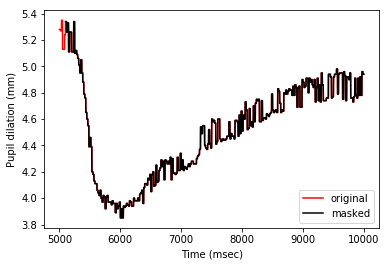

In [40]:
f, ax = pl.subplots(1, 1)

ax.plot(pupil_dilation.loc[:10000], 'r-', label='original')
ax.plot(pupil_dilation_masked.loc[:10000], 'k-', label='masked')
ax.legend(loc='lower right')
ax.set_xlabel('Time (msec)')
ax.set_ylabel('Pupil dilation (mm)')

Now, we smooth the data using a rolling window. This is facilitated by functions provided by Pandas:

* `smooth_samples` is the size of the window in samples
* `win_type` is the shape of the window
* `center` means to center the window at the current sample being averaged
* `min_periods` indicates the minimum number of samples for a valid value to be computed. If too many samples in the window are missing, the result for that point will be NaN.

In [ ]:
# Set up the window
window = pupil_dilation_masked.rolling(smooth_samples, win_type=smooth_window, center=True, min_periods=smooth_samples_min)

# The result will be the average within the window
pupil_dilation_smoothed = window.mean()

As shown in the plot, this smooths the data nicely.

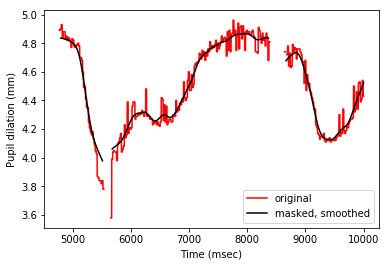

In [ ]:
f, ax = pl.subplots(1, 1)

ax.plot(pupil_dilation.loc[:10000], 'r-', label='original')
ax.plot(pupil_dilation_smoothed.loc[:10000], 'k-', label='masked, smoothed')
ax.legend(loc='lower right')
ax.set_xlabel('Time (msec)')
ax.set_ylabel('Pupil dilation (mm)')

Now interpolate the smoothed data to fill in missing segments. Again, we use Pandas to help with the interpolation. This may actually be better done via Numpy (thus giving us more precise control over how the interpolation occurs). The next plot shows the final result of the various steps used to clean up the data.

In [ ]:
pupil_dilation_interpolated = pupil_dilation_smoothed.interpolate(interpolation_method)

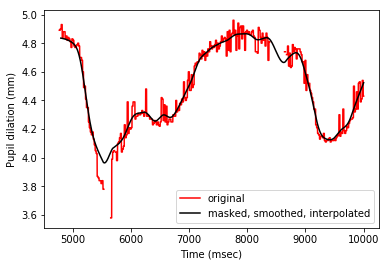

In [ ]:
f, ax = pl.subplots(1, 1)

ax.plot(pupil_dilation.loc[:10000], 'r-', label='original')
ax.plot(pupil_dilation_interpolated.loc[:10000], 'k-', label='masked, smoothed, interpolated')
ax.legend(loc='lower right')
ax.set_xlabel('Time (msec)')
ax.set_ylabel('Pupil dilation (mm)')

Show a larger range of data to show that we have cleaned up the data nicely and eliminated a lot of artifacts.

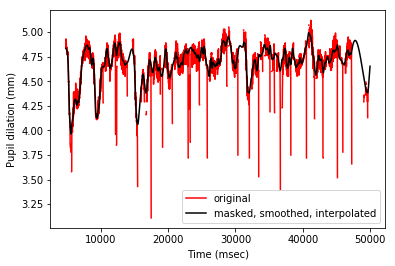

In [ ]:
f, ax = pl.subplots(1, 1)

lower, upper = 0, 50000

ax.plot(pupil_dilation.loc[lower:upper], 'r-', label='original')
ax.plot(pupil_dilation_interpolated.loc[lower:upper], 'k-', label='masked, smoothed, interpolated')
ax.legend(loc='lower right')
ax.set_xlabel('Time (msec)')
ax.set_ylabel('Pupil dilation (mm)')